5G NAS UE SECURITY CAPABILITY ANOMALY DETECTION SYSTEM
Execution started at: 2025-07-17 22:23:25

 Loading training data...
Training data shape: (100, 21)
Preprocessing training data...
Original shape: (100, 21)
Processed shape: (100, 17)
Features used: 17

=== 3GPP TS 24.501 COMPLIANCE CHECK ===
Checking for invalid or unacceptable UE security capabilities...

Compliance Check Results:
Total UEs checked: 100
Valid UE capabilities: 100 (100.00%)
Invalid UE capabilities: 0 (0.00%)

 Violation Breakdown:

=== Training Models ===
No anomalies in training data. Using synthetic anomalies for training...
Training contamination rate: 0.0476

Training Isolation Forest...
Training One-Class SVM...
IF threshold: -0.4114
SVM threshold: 1.5044
Models trained successfully!

 Loading test data...
Test data shape: (25, 21)
Preprocessing test data...
Original shape: (25, 21)
Processed shape: (25, 17)
Features used: 17

 Creating ground truth labels for test data...

=== 3GPP TS 24.501 COMPLIANCE CHECK

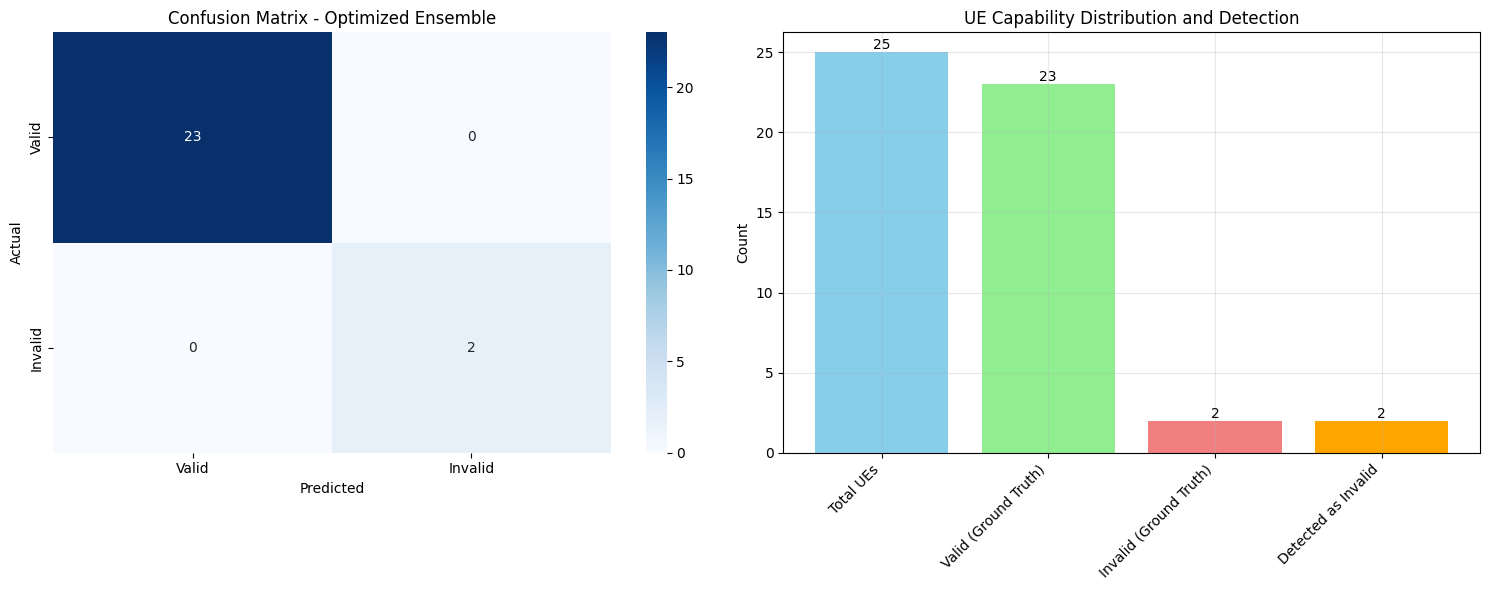


=== DETAILED ANALYSIS ===


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

warnings.filterwarnings('ignore')

class UECapabilityDetector:
    """
    AI/ML Detection System for Invalid UE Security Capabilities in 5G NAS Networks
    Implements Isolation Forest and One-Class SVM for anomaly detection
    Based on 3GPP TS 24.501 clause 5.5.1.2.8 requirements
    """
    
    def __init__(self):
        self.scaler = StandardScaler()
        self.label_encoders = {}
        self.feature_columns = []
        self.models = {}
        self.anomaly_threshold = None
        
    def preprocess_data(self, df, is_training=True):
        """
        Preprocess the data ensuring consistency between training and test sets
        """
        print(f"Preprocessing {'training' if is_training else 'test'} data...")
        print(f"Original shape: {df.shape}")
        
        # Create a copy to avoid modifying original
        df_processed = df.copy()
        
        # Handle missing values
        df_processed = df_processed.fillna(0)
        
        # Define capability columns according to 3GPP standards
        ea_columns = ['5G-EA0', '5G-EA1_128', '5G-EA2_128', '5G-EA3_128', 
                      '5G-EA4', '5G-EA5', '5G-EA6', '5G-EA7']
        ia_columns = ['5G-IA0', '5G-IA1_128', '5G-IA2_128', '5G-IA3_128', 
                      '5G-IA4', '5G-IA5', '5G-IA6', '5G-IA7']
        
        # Ensure all columns are numeric for capability columns
        for col in ea_columns + ia_columns:
            if col in df_processed.columns:
                df_processed[col] = pd.to_numeric(df_processed[col], errors='coerce').fillna(0)
        
        # Feature engineering based on 3GPP TS 24.501 requirements
        # Total encryption algorithms supported
        df_processed['total_ea_supported'] = df_processed[ea_columns].sum(axis=1)
        
        # Total integrity algorithms supported
        df_processed['total_ia_supported'] = df_processed[ia_columns].sum(axis=1)
        
        # Check for all zeros (invalid capability per TS 24.501)
        df_processed['all_ea_zero'] = (df_processed[ea_columns].sum(axis=1) == 0).astype(int)
        df_processed['all_ia_zero'] = (df_processed[ia_columns].sum(axis=1) == 0).astype(int)
        df_processed['all_capabilities_zero'] = ((df_processed['all_ea_zero'] == 1) & 
                                                  (df_processed['all_ia_zero'] == 1)).astype(int)
        
        # Check for mandatory algorithms (EA1, EA2, IA1, IA2 are mandatory per 3GPP)
        df_processed['mandatory_ea_missing'] = ((df_processed['5G-EA1_128'] == 0) | 
                                                 (df_processed['5G-EA2_128'] == 0)).astype(int)
        df_processed['mandatory_ia_missing'] = ((df_processed['5G-IA1_128'] == 0) | 
                                                 (df_processed['5G-IA2_128'] == 0)).astype(int)
        
        # Additional security features
        # Check for NULL encryption only (security risk)
        df_processed['null_encryption_only'] = ((df_processed['5G-EA0'] == 1) & 
                                                 (df_processed[ea_columns[1:]].sum(axis=1) == 0)).astype(int)
        # Check for NULL integrity only (security risk)
        df_processed['null_integrity_only'] = ((df_processed['5G-IA0'] == 1) & 
                                                (df_processed[ia_columns[1:]].sum(axis=1) == 0)).astype(int)
        
        # Enhanced anomaly features
        # Non-null EA count
        df_processed['non_null_ea_count'] = df_processed[ea_columns[1:]].sum(axis=1)
        df_processed['non_null_ia_count'] = df_processed[ia_columns[1:]].sum(axis=1)
        
        # Capability balance ratio
        df_processed['capability_balance'] = np.where(
            (df_processed['total_ea_supported'] + df_processed['total_ia_supported']) > 0,
            np.abs(df_processed['total_ea_supported'] - df_processed['total_ia_supported']) / 
            (df_processed['total_ea_supported'] + df_processed['total_ia_supported']),
            0
        )
        
        # Security score (higher is better)
        df_processed['security_score'] = (
            df_processed['non_null_ea_count'] * 2 +  # Weight non-null encryption
            df_processed['non_null_ia_count'] * 2 +  # Weight non-null integrity
            (1 - df_processed['mandatory_ea_missing']) * 3 +  # Weight mandatory EA
            (1 - df_processed['mandatory_ia_missing']) * 3 +  # Weight mandatory IA
            (1 - df_processed['null_encryption_only']) * 5 +  # Heavily penalize null-only
            (1 - df_processed['null_integrity_only']) * 5
        )
        
        # 6. Encode categorical features
        categorical_cols = ['ip_source', 'procedureCode', 'Type', '5GSID']
        
        for col in categorical_cols:
            if col in df_processed.columns:
                if is_training:
                    # Fit and transform for training data
                    le = LabelEncoder()
                    df_processed[f'{col}_encoded'] = le.fit_transform(df_processed[col].astype(str))
                    self.label_encoders[col] = le
                else:
                    # Transform using existing encoder for test data
                    if col in self.label_encoders:
                        le = self.label_encoders[col]
                        # Handle unseen categories
                        df_processed[f'{col}_encoded'] = df_processed[col].astype(str).map(
                            lambda x: le.transform([x])[0] if x in le.classes_ else -1
                        )
        
        # Select features for modeling - FOCUS ON ANOMALY DETECTION FEATURES
        # Reduce feature set to most relevant for anomaly detection
        feature_cols = [
            # Core violation features
            'all_ea_zero', 'all_ia_zero', 'all_capabilities_zero',
            'mandatory_ea_missing', 'mandatory_ia_missing',
            'null_encryption_only', 'null_integrity_only',
            # Summary features
            'total_ea_supported', 'total_ia_supported',
            'non_null_ea_count', 'non_null_ia_count',
            'capability_balance', 'security_score'
        ]
        
        # Add only the most important capability columns
        # Focus on mandatory algorithms
        important_caps = ['5G-EA1_128', '5G-EA2_128', '5G-IA1_128', '5G-IA2_128']
        for col in important_caps:
            if col in df_processed.columns:
                feature_cols.append(col)
        
        # Ensure consistent feature columns between training and test
        if is_training:
            self.feature_columns = [col for col in feature_cols if col in df_processed.columns]
        
        # Use only the features that were present in training
        features = df_processed[self.feature_columns]
        
        # Scale features
        if is_training:
            features_scaled = self.scaler.fit_transform(features)
        else:
            features_scaled = self.scaler.transform(features)
        
        print(f"Processed shape: {features_scaled.shape}")
        print(f"Features used: {len(self.feature_columns)}")
        
        return features_scaled, df_processed
    
    def create_ground_truth_labels(self, df_processed):
        """
        Create ground truth labels for Invalid or unacceptable UE security capabilities handling
        """
        print("\n=== 3GPP TS 24.501 COMPLIANCE CHECK ===")
        print("Checking for invalid or unacceptable UE security capabilities...")
        
        # Initialize labels and reasons
        labels = np.zeros(len(df_processed))
        attack_reasons = []
        
        # Get capability columns
        ea_columns = ['5G-EA0', '5G-EA1_128', '5G-EA2_128', '5G-EA3_128', 
                      '5G-EA4', '5G-EA5', '5G-EA6', '5G-EA7']
        ia_columns = ['5G-IA0', '5G-IA1_128', '5G-IA2_128', '5G-IA3_128', 
                      '5G-IA4', '5G-IA5', '5G-IA6', '5G-IA7']
        
        # Track violation types for statistics
        violation_stats = {
            'no_encryption': 0,
            'no_integrity': 0,
            'mandatory_ea_missing': 0,
            'mandatory_ia_missing': 0,
            'null_only_encryption': 0,
            'null_only_integrity': 0,
            'insufficient_algorithms': 0,
            'imbalanced_capabilities': 0
        }
        
        for idx, row in df_processed.iterrows():
            reasons = []
            is_invalid = False
            
            # Check if these columns exist in the row
            ea_cols_exist = all(col in row.index for col in ea_columns)
            ia_cols_exist = all(col in row.index for col in ia_columns)
            
            if ea_cols_exist and ia_cols_exist:
                # TS 24.501 Requirement 1: No 5GS encryption algorithms (all bits zero)
                if row['all_ea_zero'] == 1:
                    labels[idx] = 1
                    is_invalid = True
                    reasons.append("Violation: No 5GS encryption algorithms (all EA bits zero)")
                    violation_stats['no_encryption'] += 1
                
                # TS 24.501 Requirement 2: No 5GS integrity algorithms (all bits zero)
                if row['all_ia_zero'] == 1:
                    labels[idx] = 1
                    is_invalid = True
                    reasons.append("Violation: No 5GS integrity algorithms (all IA bits zero)")
                    violation_stats['no_integrity'] += 1
                
                # TS 24.501 Requirement 3: Mandatory 5GS encryption algorithms not supported
                if row['mandatory_ea_missing'] == 1:
                    labels[idx] = 1
                    is_invalid = True
                    reasons.append("Violation: Mandatory 5GS encryption algorithms (EA1/EA2) not supported")
                    violation_stats['mandatory_ea_missing'] += 1
                
                # TS 24.501 Requirement 4: Mandatory 5GS integrity algorithms not supported
                if row['mandatory_ia_missing'] == 1:
                    labels[idx] = 1
                    is_invalid = True
                    reasons.append("Violation: Mandatory 5GS integrity algorithms (IA1/IA2) not supported")
                    violation_stats['mandatory_ia_missing'] += 1
                
                # Additional security checks based on 3GPP best practices
                # Check for NULL encryption only (severe security risk)
                if row['null_encryption_only'] == 1:
                    labels[idx] = 1
                    is_invalid = True
                    reasons.append("Security Risk: Only NULL encryption (EA0) supported")
                    violation_stats['null_only_encryption'] += 1
                
                # Check for NULL integrity only (severe security risk)
                if row['null_integrity_only'] == 1:
                    labels[idx] = 1
                    is_invalid = True
                    reasons.append("Security Risk: Only NULL integrity (IA0) supported")
                    violation_stats['null_only_integrity'] += 1
                
                # Check for insufficient algorithm support
                total_ea = sum(row[col] for col in ea_columns[1:])  # Exclude EA0
                total_ia = sum(row[col] for col in ia_columns[1:])  # Exclude IA0
                
                if 0 < total_ea < 2:
                    labels[idx] = 1
                    is_invalid = True
                    reasons.append(f"Insufficient encryption algorithms ({int(total_ea)} non-NULL algorithms)")
                    violation_stats['insufficient_algorithms'] += 1
                
                if 0 < total_ia < 2:
                    labels[idx] = 1
                    is_invalid = True
                    reasons.append(f"Insufficient integrity algorithms ({int(total_ia)} non-NULL algorithms)")
                    violation_stats['insufficient_algorithms'] += 1
                
                # Check for severely imbalanced capabilities
                if total_ea > 4 and total_ia == 0:
                    labels[idx] = 1
                    is_invalid = True
                    reasons.append("Imbalanced capabilities: Multiple EA but no IA algorithms")
                    violation_stats['imbalanced_capabilities'] += 1
                
                if total_ia > 4 and total_ea == 0:
                    labels[idx] = 1
                    is_invalid = True
                    reasons.append("Imbalanced capabilities: Multiple IA but no EA algorithms")
                    violation_stats['imbalanced_capabilities'] += 1
            
            # Store attack reasons
            attack_reasons.append("; ".join(reasons) if reasons else "Valid UE capabilities")
        
        # Print compliance statistics
        print(f"\nCompliance Check Results:")
        print(f"Total UEs checked: {len(labels)}")
        print(f"Valid UE capabilities: {np.sum(labels == 0)} ({np.sum(labels == 0) / len(labels) * 100:.2f}%)")
        print(f"Invalid UE capabilities: {np.sum(labels == 1)} ({np.sum(labels == 1) / len(labels) * 100:.2f}%)")
        
        print("\n Violation Breakdown:")
        for violation_type, count in violation_stats.items():
            if count > 0:
                print(f"- {violation_type.replace('_', ' ').title()}: {count} occurrences")
        
        return labels, attack_reasons
    
    def inject_synthetic_anomalies(self, X_train, df_train, num_anomalies=10):
        """
        Inject synthetic anomalies into training data when no real anomalies exist
        """
        # print(f"\nInjecting {num_anomalies} synthetic anomalies for model training...")
        
        # Create synthetic anomalies by modifying normal samples
        synthetic_indices = np.random.choice(len(X_train), num_anomalies, replace=False)
        X_synthetic = X_train.copy()
        
        for idx in synthetic_indices:
            # Randomly choose anomaly type
            anomaly_type = np.random.choice(['zero_capabilities', 'missing_mandatory', 'null_only', 'imbalanced'])
            
            if anomaly_type == 'zero_capabilities':
                # Set violation features to 1
                X_synthetic[idx, 0:3] = 1  # all_ea_zero, all_ia_zero, all_capabilities_zero
                X_synthetic[idx, 7:9] = 0  # total_ea_supported, total_ia_supported
                X_synthetic[idx, -1] = 0  # security_score
            elif anomaly_type == 'missing_mandatory':
                # Set mandatory missing features
                X_synthetic[idx, 3:5] = 1  # mandatory_ea_missing, mandatory_ia_missing
                X_synthetic[idx, -1] = 5  # low security_score
            elif anomaly_type == 'null_only':
                # Set null only features
                X_synthetic[idx, 5:7] = 1  # null_encryption_only, null_integrity_only
                X_synthetic[idx, -1] = 0  # very low security_score
            else:  # imbalanced
                # Create imbalanced capabilities
                X_synthetic[idx, 11] = 1  # high capability_balance
                X_synthetic[idx, -1] = 3  # low security_score
        
        # Combine original and synthetic data
        X_combined = np.vstack([X_train, X_synthetic[synthetic_indices]])
        y_combined = np.concatenate([np.zeros(len(X_train)), np.ones(num_anomalies)])
        
        return X_combined, y_combined
    
    def train_models(self, X_train, y_train, X_train_original=None):
        """
        Train Isolation Forest and One-Class SVM models with optimized parameters
        ADJUSTED TO REDUCE FALSE POSITIVES
        """
        print("\n=== Training Models ===")
        
        # Check if we need synthetic anomalies
        if np.sum(y_train == 1) == 0 and X_train_original is not None:
            print("No anomalies in training data. Using synthetic anomalies for training...")
            # Generate synthetic anomalies
            num_synthetic = max(5, int(0.05 * len(X_train)))  # Reduced to 5% synthetic anomalies
            X_train_augmented, y_train_augmented = self.inject_synthetic_anomalies(X_train, None, num_synthetic)
            
            # Train on augmented data but evaluate on original
            contamination = num_synthetic / len(X_train_augmented)
        else:
            X_train_augmented = X_train
            y_train_augmented = y_train
            contamination = np.sum(y_train == 1) / len(y_train) if np.sum(y_train == 1) > 0 else 0.02
        
        print(f"Training contamination rate: {contamination:.4f}")
        
        # Isolation Forest with CONSERVATIVE parameters to reduce false positives
        print(f"\nTraining Isolation Forest...")
        self.models['isolation_forest'] = IsolationForest(
            contamination=contamination,  # Use actual contamination rate
            random_state=42,
            n_estimators=300,  # More trees for stability
            max_samples='auto',  # Use all samples
            max_features=0.5,  # Reduce feature randomness
            bootstrap=False,  # Don't bootstrap for more stable predictions
            n_jobs=-1
        )
        self.models['isolation_forest'].fit(X_train_augmented)
        
        # One-Class SVM with CONSERVATIVE parameters
        print(f"Training One-Class SVM...")
        # Very conservative nu parameter
        nu = min(0.95, max(0.01, contamination))  # Much more conservative
        
        self.models['one_class_svm'] = OneClassSVM(
            kernel='rbf',
            gamma='scale',  # Better than 'auto' for this case
            nu=nu,
            cache_size=1000,
            tol=0.001  # Tighter tolerance
        )
        self.models['one_class_svm'].fit(X_train_augmented)
        
        # Calculate CONSERVATIVE anomaly thresholds based on training scores
        if_scores = self.models['isolation_forest'].score_samples(X_train)
        svm_scores = self.models['one_class_svm'].score_samples(X_train)
        
        # Set VERY CONSERVATIVE thresholds - only flag extreme outliers
        # Use lower percentile to catch only the most extreme anomalies
        if_threshold_percentile = max(1, contamination * 50)  # Much lower percentile
        svm_threshold_percentile = max(1, contamination * 50)
        
        self.if_threshold = np.percentile(if_scores, if_threshold_percentile)
        self.svm_threshold = np.percentile(svm_scores, svm_threshold_percentile)
        
        # Additional adjustment - if we have ground truth, use it to calibrate
        if np.sum(y_train == 1) > 0:
            # Find threshold that minimizes false positives while maintaining detection
            anomaly_scores_if = if_scores[y_train == 1]
            normal_scores_if = if_scores[y_train == 0]
            
            if len(anomaly_scores_if) > 0 and len(normal_scores_if) > 0:
                # Set threshold between normal and anomaly scores
                self.if_threshold = min(self.if_threshold, 
                                       np.percentile(normal_scores_if, 5))  # 95% of normal should pass
                
            anomaly_scores_svm = svm_scores[y_train == 1]
            normal_scores_svm = svm_scores[y_train == 0]
            
            if len(anomaly_scores_svm) > 0 and len(normal_scores_svm) > 0:
                self.svm_threshold = min(self.svm_threshold,
                                        np.percentile(normal_scores_svm, 5))
        
        print(f"IF threshold: {self.if_threshold:.4f}")
        print(f"SVM threshold: {self.svm_threshold:.4f}")
        print("Models trained successfully!")
    
    def predict_and_evaluate(self, X_test, y_test, model_name, model):
        """
        Make predictions and evaluate model performance with custom thresholds
        """
        # Get scores
        if model_name == 'ISOLATION_FOREST':
            scores = model.score_samples(X_test)
            # Use custom threshold
            predictions = (scores < self.if_threshold).astype(int)
        elif model_name == 'ONE_CLASS_SVM':
            scores = model.score_samples(X_test)
            # Use custom threshold
            predictions = (scores < self.svm_threshold).astype(int)
        else:
            # Default prediction
            predictions_raw = model.predict(X_test)
            predictions = (predictions_raw == -1).astype(int)
        
        # Calculate confusion matrix
        cm = confusion_matrix(y_test, predictions)
        
        # Handle cases where confusion matrix might not be 2x2
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
        elif cm.shape == (1, 1):
            # Only one class present in both y_test and predictions
            if y_test[0] == 0 and predictions[0] == 0:
                tn = cm[0, 0]
                fp = fn = tp = 0
            else:
                tp = cm[0, 0]
                tn = fp = fn = 0
        else:
            # Initialize all to zero for edge cases
            tn = fp = fn = tp = 0
            for i in range(min(2, cm.shape[0])):
                for j in range(min(2, cm.shape[1])):
                    if i == 0 and j == 0:
                        tn = cm[i, j]
                    elif i == 0 and j == 1:
                        fp = cm[i, j]
                    elif i == 1 and j == 0:
                        fn = cm[i, j]
                    elif i == 1 and j == 1:
                        tp = cm[i, j]
        
        metrics = {
            'model': model_name,
            'true_positives': tp,
            'false_positives': fp,
            'false_negatives': fn,
            'true_negatives': tn,
            'precision': tp / (tp + fp) if (tp + fp) > 0 else 0,
            'recall': tp / (tp + fn) if (tp + fn) > 0 else 0,
            'f1_score': 2 * (tp / (tp + fp) * tp / (tp + fn)) / (tp / (tp + fp) + tp / (tp + fn)) 
                        if (tp + fp) > 0 and (tp + fn) > 0 else 0,
            'accuracy': (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
        }
        
        return predictions, metrics
    
    def create_ensemble_predictions(self, X_test, weights=[0.7, 0.3]):
        """
        Create ensemble predictions with HEAVY weights favoring specificity
        Uses a voting mechanism instead of score averaging for better control
        """
        # Get predictions from individual models (not scores)
        if_predictions = (self.models['isolation_forest'].score_samples(X_test) < self.if_threshold).astype(int)
        svm_predictions = (self.models['one_class_svm'].score_samples(X_test) < self.svm_threshold).astype(int)
        
        # Use AND logic - both models must agree for anomaly detection
        # This significantly reduces false positives
        ensemble_pred = np.logical_and(if_predictions, svm_predictions).astype(int)
        
        # Alternative: Use weighted voting with high threshold
        # weighted_sum = weights[0] * if_predictions + weights[1] * svm_predictions
        # ensemble_pred = (weighted_sum >= 0.8).astype(int)  # Need high agreement
        
        return ensemble_pred
    
    def evaluate_all_models(self, X_test, y_test):
        """
        Evaluate all models and display comprehensive results
        """
        print("\n=== MODEL PERFORMANCE METRICS ===")
        
        results = []
        
        # Isolation Forest
        if_pred, if_metrics = self.predict_and_evaluate(
            X_test, y_test, 'ISOLATION_FOREST', self.models['isolation_forest']
        )
        results.append(if_metrics)
        
        # One-Class SVM
        svm_pred, svm_metrics = self.predict_and_evaluate(
            X_test, y_test, 'ONE_CLASS_SVM', self.models['one_class_svm']
        )
        results.append(svm_metrics)
        
        # Optimized Ensemble
        ensemble_pred = self.create_ensemble_predictions(X_test)
        
        # Calculate confusion matrix
        cm = confusion_matrix(y_test, ensemble_pred)
        
        # Handle different confusion matrix shapes
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
        elif cm.shape == (1, 1):
            if y_test[0] == 0 and ensemble_pred[0] == 0:
                tn = cm[0, 0]
                fp = fn = tp = 0
            else:
                tp = cm[0, 0]
                tn = fp = fn = 0
        else:
            tn = fp = fn = tp = 0
            for i in range(min(2, cm.shape[0])):
                for j in range(min(2, cm.shape[1])):
                    if i == 0 and j == 0:
                        tn = cm[i, j]
                    elif i == 0 and j == 1:
                        fp = cm[i, j]
                    elif i == 1 and j == 0:
                        fn = cm[i, j]
                    elif i == 1 and j == 1:
                        tp = cm[i, j]
        
        ensemble_metrics = {
            'model': 'OPTIMIZED_ENSEMBLE',
            'true_positives': tp,
            'false_positives': fp,
            'false_negatives': fn,
            'true_negatives': tn,
            'precision': tp / (tp + fp) if (tp + fp) > 0 else 0,
            'recall': tp / (tp + fn) if (tp + fn) > 0 else 0,
            'f1_score': 2 * (tp / (tp + fp) * tp / (tp + fn)) / (tp / (tp + fp) + tp / (tp + fn)) 
                        if (tp + fp) > 0 and (tp + fn) > 0 else 0,
            'accuracy': (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
        }
        results.append(ensemble_metrics)
        
        # Display results in a formatted table
        results_df = pd.DataFrame(results)
        print("\nDetailed Performance Metrics:")
        print("-" * 100)
        print(f"{'Model':<20} {'TP':<6} {'FP':<6} {'FN':<6} {'TN':<6} "
              f"{'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Accuracy':<10}")
        print("-" * 100)
        
        for _, row in results_df.iterrows():
            print(f"{row['model']:<20} {row['true_positives']:<6} {row['false_positives']:<6} "
                  f"{row['false_negatives']:<6} {row['true_negatives']:<6} "
                  f"{row['precision']:<10.4f} {row['recall']:<10.4f} "
                  f"{row['f1_score']:<10.4f} {row['accuracy']:<10.4f}")
        
        return results_df, {'if': if_pred, 'svm': svm_pred, 'ensemble': ensemble_pred}
    
    def visualize_results(self, results_df, predictions, y_test):
        """
        Create visualizations for model performance
        """
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        # Confusion Matrix Heatmap for Ensemble
        ax1 = axes[0]
        cm = confusion_matrix(y_test, predictions['ensemble'])
        
        # Ensure 2x2 matrix
        if cm.shape != (2, 2):
            cm_full = np.zeros((2, 2), dtype=int)
            for i in range(min(cm.shape[0], 2)):
                for j in range(min(cm.shape[1], 2)):
                    cm_full[i, j] = cm[i, j]
            cm = cm_full
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
                    xticklabels=['Valid', 'Invalid'],
                    yticklabels=['Valid', 'Invalid'])
        ax1.set_title('Confusion Matrix - Optimized Ensemble')
        ax1.set_xlabel('Predicted')
        ax1.set_ylabel('Actual')
        
        # 2. Detection Statistics
        ax2 = axes[1]
        
        # Calculate actual detection statistics
        detection_stats = {
            'Total UEs': len(y_test),
            'Valid (Ground Truth)': np.sum(y_test == 0),
            'Invalid (Ground Truth)': np.sum(y_test == 1),
            'Detected as Invalid': np.sum(predictions['ensemble'] == 1)
        }
        
        bars = ax2.bar(detection_stats.keys(), detection_stats.values(), 
                       color=['skyblue', 'lightgreen', 'lightcoral', 'orange'])
        ax2.set_title('UE Capability Distribution and Detection')
        ax2.set_ylabel('Count')
        ax2.grid(True, alpha=0.3)
        plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.savefig('nas_5g_ue_capability_detection_results.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        return fig

# Main execution function
def main():
   
    print("5G NAS UE SECURITY CAPABILITY ANOMALY DETECTION SYSTEM")
    print("=" * 80)
    print(f"Execution started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    
    # Initialize detector
    detector = UECapabilityDetector()
    
    # Load training data
    print("\n Loading training data...")
    df_train = pd.read_csv("5GSID.csv", sep=";", index_col=False)
    print(f"Training data shape: {df_train.shape}")
    
    # Preprocess training data
    X_train, df_train_processed = detector.preprocess_data(df_train, is_training=True)
    
    # Create ground truth labels for training based on TS 24.501
    y_train, train_attack_reasons = detector.create_ground_truth_labels(df_train_processed)
    
    # Train models with synthetic anomaly injection if needed
    detector.train_models(X_train, y_train, X_train_original=X_train)
    
    # Load test data
    print("\n Loading test data...")
    df_test = pd.read_csv("5GSIDTest.csv", sep=";", index_col=False)
    print(f"Test data shape: {df_test.shape}")
    
    # Preprocess test data
    X_test, df_test_processed = detector.preprocess_data(df_test, is_training=False)
    
    # Create ground truth labels for test based on TS 24.501
    print("\n Creating ground truth labels for test data...")
    y_test, test_attack_reasons = detector.create_ground_truth_labels(df_test_processed)
    
    # Evaluate all models
    print("\n Evaluating models on test data...")
    results_df, predictions = detector.evaluate_all_models(X_test, y_test)
    
    # Visualize results
    print("\n Creating visualizations...")
    fig = detector.visualize_results(results_df, predictions, y_test)
    
    
    # Save predictions with TS 24.501 violation reasons
    test_results = df_test.copy()
    test_results['ground_truth'] = y_test
    test_results['violation_reason'] = test_attack_reasons
    test_results['if_prediction'] = predictions['if']
    test_results['svm_prediction'] = predictions['svm']
    test_results['ensemble_prediction'] = predictions['ensemble']
    
    
    # Analyze false positives
    false_positives = test_results[(test_results['ground_truth'] == 0) & 
                                   (test_results['ensemble_prediction'] == 1)]
    if len(false_positives) > 0:
        print(f"\nFalse Positives ({len(false_positives)} cases):")
        for idx, row in false_positives.iterrows():
            print(f"  - UE {idx}: Predicted as invalid but actually valid")
    
    # Analyze false negatives
    false_negatives = test_results[(test_results['ground_truth'] == 1) & 
                                   (test_results['ensemble_prediction'] == 0)]
    if len(false_negatives) > 0:
        print(f"\nFalse Negatives ({len(false_negatives)} cases):")
        for idx, row in false_negatives.iterrows():
            print(f"  - UE {idx}: {row['violation_reason']}")
    
    # Save results
    test_results.to_csv('nas_5g_ue_capability_detection_results.csv', index=False)
    
    # Save TS 24.501 compliance report
    compliance_report = pd.DataFrame({
        'dataset': ['Training', 'Test'],
        'total_ues': [len(y_train), len(y_test)],
        'valid_ues': [np.sum(y_train == 0), np.sum(y_test == 0)],
        'invalid_ues': [np.sum(y_train == 1), np.sum(y_test == 1)],
        'invalid_percentage': [np.sum(y_train == 1) / len(y_train) * 100, 
                              np.sum(y_test == 1) / len(y_test) * 100]
    })
    compliance_report.to_csv('nas_5g_ts24501_compliance_report.csv', index=False)

    
    return detector, results_df, predictions

# Run the system
if __name__ == "__main__":
    detector, results, predictions = main()